# Kelly Criterion

In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize_scalar
from scipy.integrate import quad
from scipy.stats import norm
from scipy import stats

import matplotlib.pyplot as plt 

In [19]:
data = 'https://raw.githubusercontent.com/fadeeva/stock_market_research/refs/heads/master/data/%5EGSPC_2002-01-01_2022-12-31_d.csv'
df = pd.read_csv(data, parse_dates=True, index_col=0)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-12-31,1161.020020,1161.160034,1148.040039,1148.079956,943600000,0,0
2002-01-02,1148.079956,1154.670044,1136.229980,1154.670044,1171000000,0,0
2002-01-03,1154.670044,1165.270020,1154.010010,1165.270020,1398900000,0,0
2002-01-04,1165.270020,1176.550049,1163.420044,1172.510010,1513000000,0,0
2002-01-07,1172.510010,1176.969971,1163.550049,1164.890015,1308300000,0,0


In [21]:
mon_returns = df['Close'].resample('M').last().pct_change().dropna().to_frame()
mon_returns.head()

,Close
Date,
2002-01-31,-0.015574
2002-02-28,-0.020766
2002-03-31,0.036739
2002-04-30,-0.061418
2002-05-31,-0.009081


In [23]:
return_params = (
    mon_returns['Close']
    .rolling(25)
    .agg(['mean', 'std'])
    .dropna()
)
return_params.head()

,mean,std
Date,,
2004-01-31,0.000639,0.050386
2004-02-29,0.001750,0.050319
2004-03-31,0.001926,0.050245
2004-04-30,-0.000215,0.049839
2004-05-31,0.002725,0.048219


## Compute the optimal position size

In [24]:
def norm_integral(f, mean, std):
    val, er = quad(
        lambda s: np.log(1 + f * s) * norm.pdf(s, mean, std),
        mean - 3 * std,
        mean + 3 * std,
    )
    return -val

In [25]:
def get_kelly(data):
    solution = minimize_scalar(
        norm_integral, 
        args=(data['mean'], data['std']),
        bounds=[0, 2],
        method='bounded'
    )
    return solution.x

<AxesSubplot:xlabel='Date'>

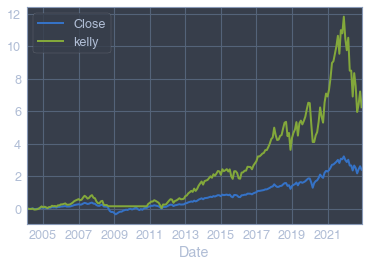

In [29]:
mon_returns['f'] = return_params.apply(get_kelly, axis=1)
(
    mon_returns[['Close']]
    .assign(kelly=mon_returns['Close'].mul(mon_returns.f.shift()))
    .dropna()
    .loc['2002-01-31':]
    .add(1).cumprod().sub(1)
    .plot(lw=2)
)

## Capital

In [40]:
N = 100
draw = 10

kelly = lambda param: (param[0]*param[1] - 1) / (param[0] - 1)

start_cap = 100_000
pool_1 = []
pool_2 = []

for _ in range(draw):
    st1 = [start_cap]
    st2 = [start_cap]
    
    results = stats.bernoulli.rvs(p=.3, size=N)
    coeffs = np.round(np.random.uniform(1.7, 5, N), 2)
    p = np.round(np.random.uniform(.3, .6, N), 2)
    
    for k, v, result in zip(coeffs, p, results):
        c = kelly([k, v])
        if c > 0:
            bet = start_cap*c if st1[-1] > start_cap else st1[-1]*c
            bet2 = start_cap // 10 * c
        else:
            continue
            
        if st1[-1] > start_cap*.05:
            if result:
                cap1 = st1[-1] + bet*k
            else:
                cap1 = st1[-1] - bet
                if cap1 < 0:
                    break
            st1.append(cap1)
        else:
            break
            
        if st2[-1] > start_cap*.05:
            if result:
                cap = st1[-1] + bet2*k
            else:
                cap = st1[-1] - bet2
                if cap1 < 0:
                    break
            st2.append(cap)
        
    pool_1.append(st1)
    pool_2.append(st2)
    

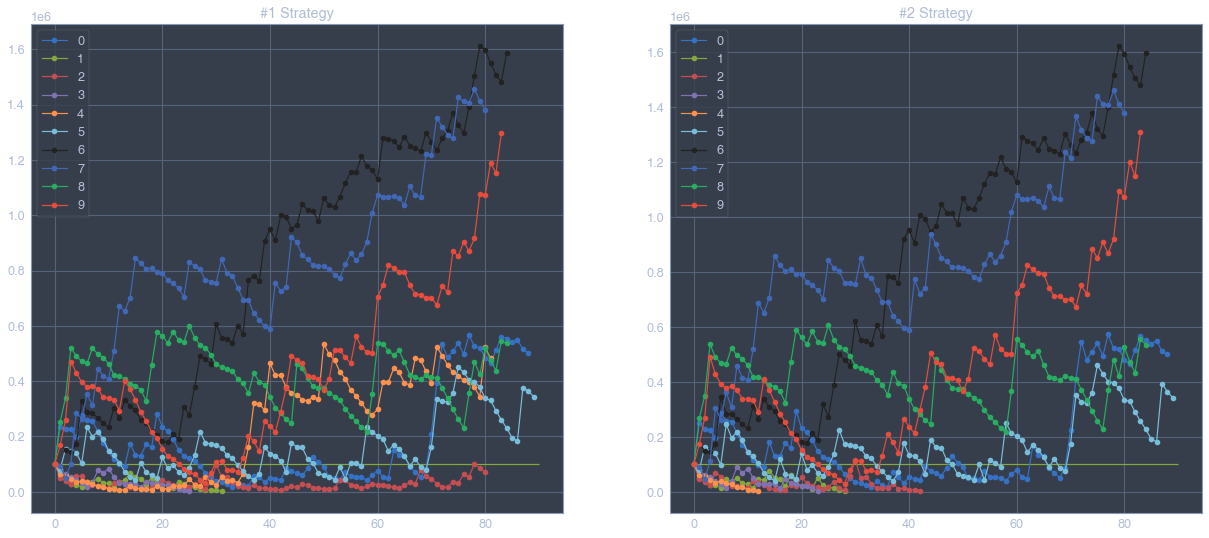

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(21, 9))

for n, st in enumerate(pool_1):
    axs[0].plot(np.arange(len(st)), st, marker='o', label=n)
    
axs[0].hlines(start_cap, 0, max([len(st) for st in pool_1]), color='g')
axs[0].set_title('#1 Strategy')
axs[0].legend()

for n, st in enumerate(pool_2):
    axs[1].plot(np.arange(len(st)), st, marker='o', label=n)
    
axs[1].hlines(start_cap, 0, max([len(st) for st in pool_2]), color='g')
axs[1].set_title('#2 Strategy')
axs[1].legend()

In [42]:
np.round(max(i[-1] for i in pool_1), 2), np.round(max(i[-1] for i in pool_2), 2)

(1587994.75, 1598594.83)

In [43]:
print('1 strategy')
pos = 0
for n, st in enumerate(pool_1):
    pos += 1 if st[-1]>100_000 else 0
    msg = '+' if st[-1]>100_000 else '-'
    print(n, len(st), st[-1], msg)
print('------------------------------')
print(pos/draw, np.round(sum(st[-1] for st in pool_1), 2) - start_cap*draw)

1 strategy
0 89 503166.7515020034 +
1 32 3069.982004052125 -
2 81 70577.68834483974 -
3 26 2895.7290515331333 -
4 82 482835.4782392579 +
5 90 344355.97530051466 +
6 85 1587994.7527923277 +
7 81 1380805.7234742865 +
8 85 536483.2803222528 +
9 84 1295716.1961012129 +
------------------------------
0.7 5207901.56


In [44]:
print('2 strategy')
pos = 0
for n, st in enumerate(pool_2):
    pos += 1 if st[-1]>100_000 else 0
    msg = '+' if st[-1]>100_000 else '-'
    print(n, len(st), st[-1], msg)
print('------------------------------')
print(pos/draw, np.round(sum(st[-1] for st in pool_2), 2) - start_cap*draw)

2 strategy
0 89 501937.3397372975 +
1 29 4367.493567067695 -
2 43 3098.6422972553155 -
3 24 4374.962947330259 -
4 13 4599.811035596618 -
5 90 342236.8530434614 +
6 85 1598594.8304622306 +
7 81 1377454.1914408603 +
8 85 535691.4822149973 +
9 84 1310097.1676774402 +
------------------------------
0.6 4682452.77
